In [1]:
import torch
import torchvision
import time
import random
import math
import json

from PIL import Image, ImageFont, ImageDraw

In [2]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

In [3]:
evalModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=27,
    box_detections_per_img=2000
)
evalModel.eval()
evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V10.pth"))

<All keys matched successfully>

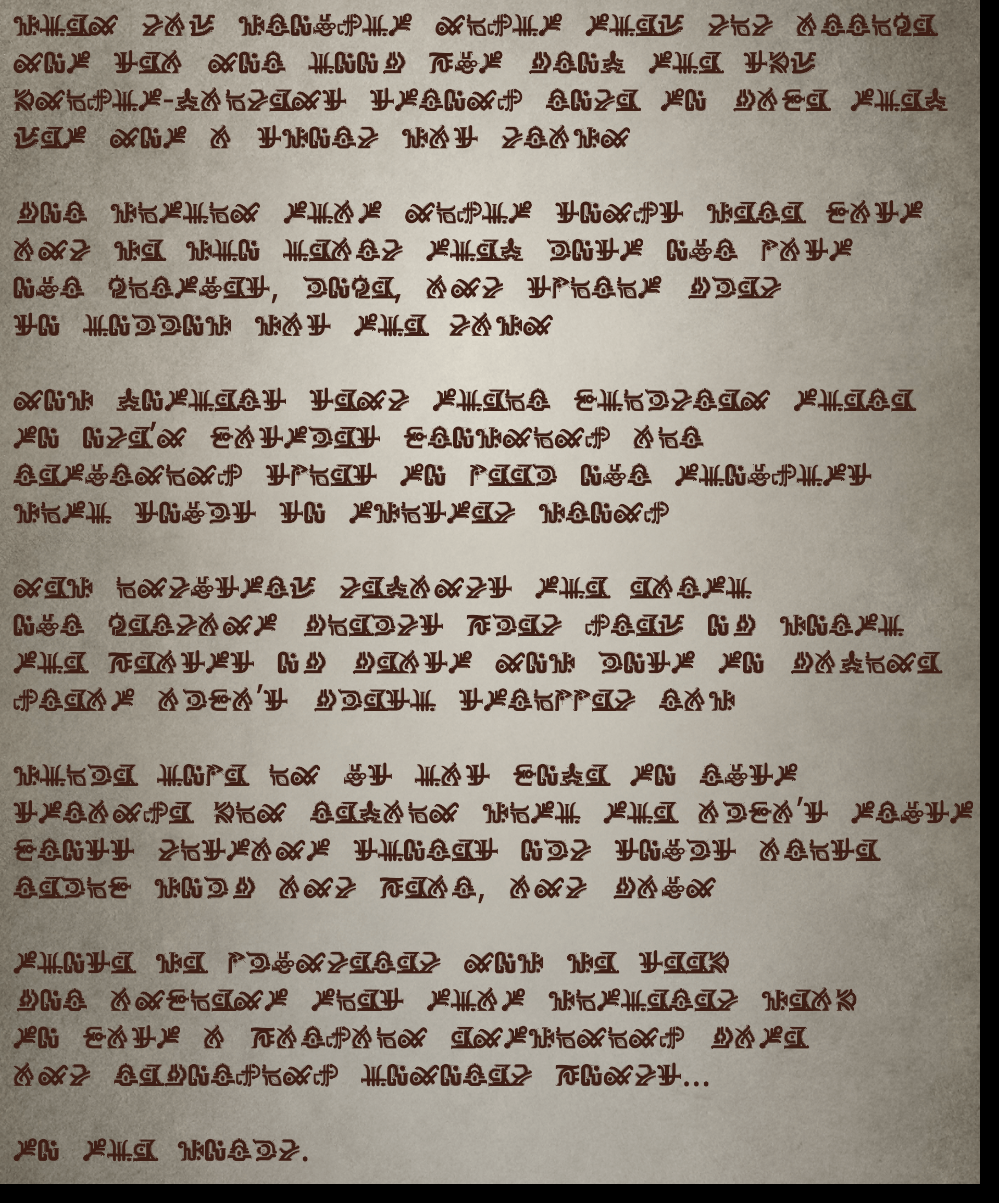

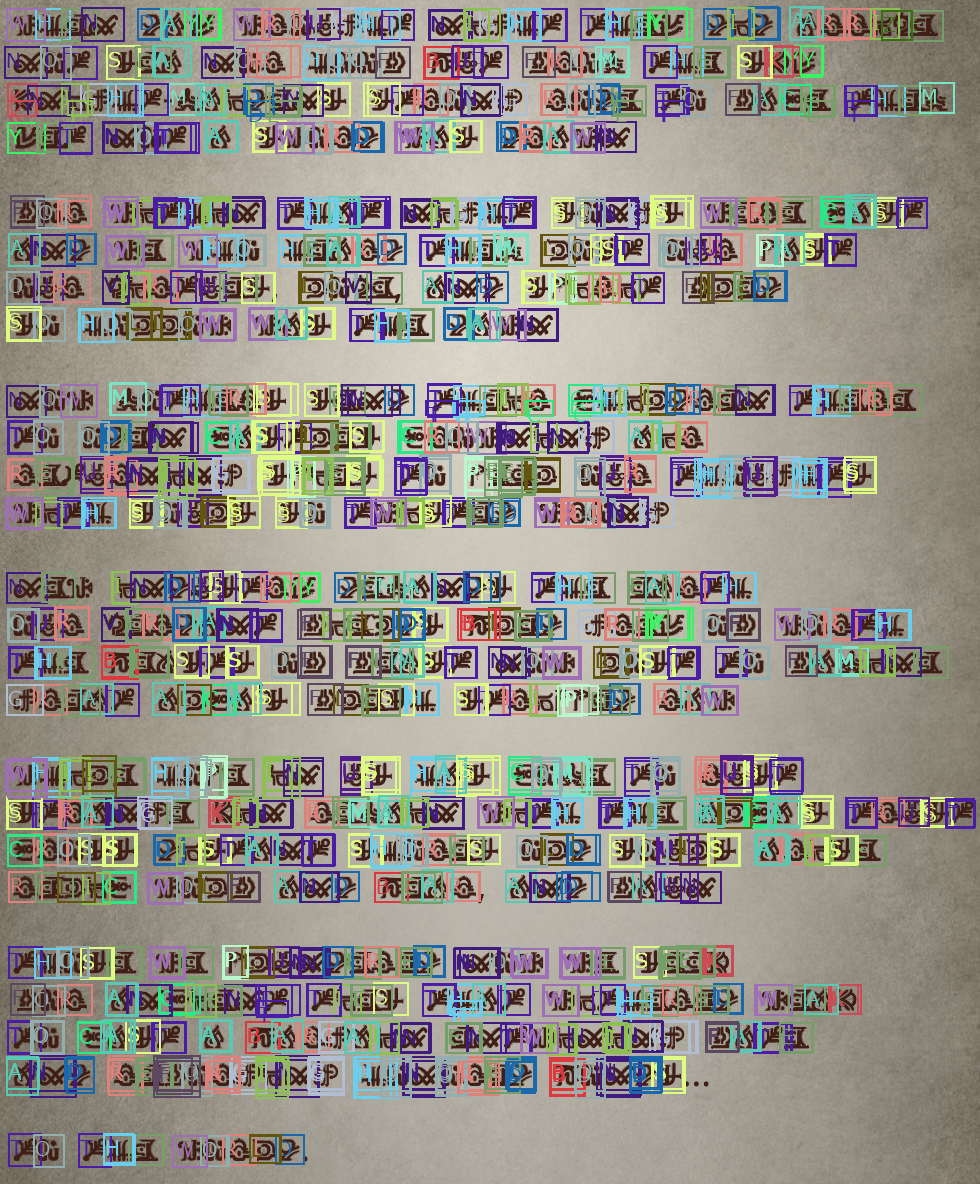

tensor([[709.2836, 233.7080, 742.5820, 265.4491],
        [709.5131, 233.7927, 742.4167, 265.4951],
        [612.0762,  86.2059, 646.3862, 115.8430],
        ...,
        [265.7635,  85.3021, 300.0000, 116.2249],
        [470.7057, 308.9301, 500.0000, 341.9820],
        [676.7956, 945.9407, 715.9568, 976.4535]], grad_fn=<SliceBackward0>)
tensor([18, 18,  5,  ...,  5,  1,  5])
tensor([1.0000, 1.0000, 1.0000,  ..., 0.8206, 0.8124, 0.8111],
       grad_fn=<SliceBackward0>)


In [97]:
def sortResults(result):
    
    indices = result['scores'].argsort(dim=0, descending=True)
    indices4 = indices.repeat(4,1).transpose(1,0)
    
    result2 = {}
    
    result2['boxes'] = result['boxes'].gather(index=indices4,dim=0)
    result2['labels'] = result['labels'].gather(index=indices,dim=0)
    result2['scores'] = result['scores'].gather(index=indices,dim=0)
    return result2

def vizTensor(tensor):
    T = torchvision.transforms.ToPILImage()
    display(T(tensor))

def filterResults(result, min_score):
    i = 0
    while i < len(result['scores']) and result['scores'][i] > min_score:
        i+=1
        
    result['boxes'] = result['boxes'][:i]
    result['labels'] = result['labels'][:i]
    result['scores'] = result['scores'][:i]
    
def applySubPicture(model,tensor,x1=0,y1=0,w1=None,h1=None,w2=None,h2=None):
    if w1 is None or w2 is None or h1 is None or h2 is None:
        w1,h1 = tensor.shape[-2:]
        w2,h2 = tensor.shape[-2:]
    
    resize = torchvision.transforms.Resize((w2,h2), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    xmod = w1/w2
    ymod = h1/h2
    
    tensor_resized = resize(tensor[:,y1:y1+h1,x1:x1+w1])
    #vizTensor(tensor_resized)
    result = model([tensor_resized])
    for i in range(len(result[0]['boxes'])):
        result[0]['boxes'][i][0] = result[0]['boxes'][i][0]*xmod + x1
        result[0]['boxes'][i][1] = result[0]['boxes'][i][1]*ymod + y1
        result[0]['boxes'][i][2] = result[0]['boxes'][i][2]*xmod + x1
        result[0]['boxes'][i][3] = result[0]['boxes'][i][3]*ymod + y1
    
    return result
        

    
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 1956
    #image_nb = 1944
    infos = json.load(f)
    #test_img = Image.open(infos[image_nb]['image'])
    test_img = Image.open("./Examples/Poem.PNG")
    #test_img = Image.open("./Examples/Envoys.PNG")
    sampleSize = 200
    increment = sampleSize//2
    scaledSize = 600
    w,h = test_img.size
    nX = 2*(w//sampleSize + int(bool(w%sampleSize))) - 1
    nY = 2*(h//sampleSize + int(bool(h%sampleSize))) - 1
    
    to_tensor = torchvision.transforms.ToTensor()
    pad = torch.nn.ZeroPad2d((0,sampleSize-(w+1)%sampleSize,0,sampleSize-(w+1)%sampleSize))
    test_tensor = to_tensor(test_img)[:3]
    test_tensor = pad(test_tensor)
    vizTensor(test_tensor)
    
    #result = applySubPicture(evalModel,test_tensor)
    full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), }
    for x in range(nX):
        for y in range(nY):
            result = applySubPicture(evalModel,test_tensor, x1=x*increment,y1=y*increment, w1=sampleSize,h1=sampleSize, w2=scaledSize,h2=scaledSize)
            full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
            full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
            full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
    
    
    full_results = sortResults(full_results)
    filterResults(full_results,0.8)
    displayCoords(test_img, full_results['boxes'].tolist(), full_results['labels'].tolist())
    print(full_results['boxes'])
    print(full_results['labels'])
    print(full_results['scores'])